In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gennorm
from ipywidgets import interact, IntSlider

## Introduction

What does fairness mean?  

- Unfair (no-regret policies): choose options with lower expected rewards over options with higher expected rewards, for example choosing less qualified job applicants over more qualified ones
- Fair (first mentioned in Joseph 2016): (with arbitrarily high probability) never at any round place higher selection probability on a less qualified applicant than on a more qualified applicant

Problems / constraints with the previously designed fair algorithm (Joseph, 2016):
- Assumes $k$ well-defined groups, each with its own mapping from features to expected rewards ($k$ linear models).
- At each round exactly one individual from each group arrives.
- Exactly one individual is chosen in each round.

Overview of sections:
- Section 2: presents a general definition of fairness without any knowledge of group membership; this definition allows for the number of individuals arriving in round to vary
- Section 3: presents a meritocratically fair online linear contextual bandit algorithm
- Section 4: 
    - regret bounds scale polynomially with, $k$, the maximum number of individuals seen in any given round
    - undesirable for large $k$
    - this motivates the authors to investigate how fairness applies for the infinite bandit setting
- Section 5 and 6: ...

**Remarks.** 

- Usually when we refer to a contextual bandit, we are referring to a system that gives us a set of arms to choose from at each time step. The expected reward of each action is a linear function of some contextual variables.

- In this paper, the model has only one arm. <u>Instead of picking arms, we pick the context that maximizes the expected reward of this arm.</u> In the context of job application, this translates to picking the potential employee that maximizes the expected job performance.

- A model of only one arm is just one linear model of contextual variables. This gives us a different perspective on the learning problem that's different from MAB: each combination of values of contextual variables can be thought as a training example to the linear model. This is a classic problem in machine learning. On top of this, this paper introduces confidence bound and a picking algorithm so that job applicants are randomly chosen in the early stage of the training process during which the model can be biased due to limited sample size.

## Model

### Assumed relationship between input features and output

Linear model assumes linear relationship between input and output variables.

For example, in the context of job application, the two input variables can be college GPA and years of work experience (abbreviated as `exp`).

In [2]:
# normalized features as mentioned in section 7.7 experiments
gpa_max, gpa_min = 1.0, -1.0
exp_max, exp_min = 1.0, -1.0

In [3]:
gpas = np.linspace(gpa_max, gpa_min, 30)
exps = np.linspace(exp_max, exp_min, 30)
gpas_for_grid, exps_for_grid = np.meshgrid(gpas, exps)

In [4]:
def job_performance(gpa, exp):
    return gpa * 0.2 + exp * 0.5 + 0  # linear relationship

In [5]:
outs_for_grid = job_performance(gpas_for_grid, exps_for_grid)

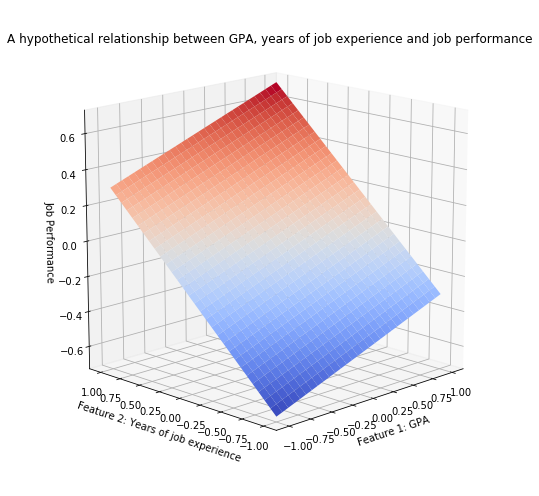

In [6]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gpas_for_grid, exps_for_grid, outs_for_grid, cmap='coolwarm')
ax.set_title('A hypothetical relationship between GPA, years of job experience and job performance')
ax.set_xlabel('Feature 1: GPA'); ax.set_ylabel('Feature 2: Years of job experience')
ax.set_zlabel('Job Performance')
ax.view_init(15, -135)
plt.tight_layout()
plt.show()

### Sample data (true linear relationship + noise)

In [7]:
def sample_applicants(num_samples, seed, vectorize=False):

    np.random.seed(seed)
    
    gpas_sampled = np.random.uniform(low=gpa_min, high=gpa_max, size=num_samples)  # pick GPA from U[0, 1]
    exps_sampled = np.random.uniform(low=exp_min, high=exp_max, size=num_samples)  # pick exp from U[0, 1]
    outs_sampled = job_performance(gpas_sampled, exps_sampled)  # get job performance

    noises = 0.1 * gennorm.rvs(beta=3, size=num_samples)  # generate sub-guassian noise
    outs_sampled += noises  # add sub-gaussian noise to job performance
    
    # https://en.wikipedia.org/wiki/Sub-Gaussian_distribution
    # https://en.wikipedia.org/wiki/Generalized_normal_distribution
    # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.gennorm.html
    
    if vectorize:
        return np.hstack([gpas_sampled.reshape(-1, 1), exps_sampled.reshape(-1, 1), np.ones((num_samples, 1))]), outs_sampled.reshape(-1, 1)
    else:
        return gpas_sampled, exps_sampled, outs_sampled

In [8]:
gpas_sampled, exps_sampled, outs_sampled = sample_applicants(500, seed=42)

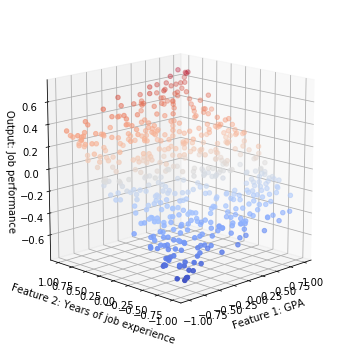

In [9]:
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(gpas_sampled, exps_sampled, outs_sampled, c=outs_sampled, cmap='coolwarm')
ax.set_xlabel('Feature 1: GPA')
ax.set_ylabel('Feature 2: Years of job experience')
ax.set_zlabel('Output: Job performance')
ax.view_init(15, -135)

plt.tight_layout()
plt.show()

## Finite action spaces: fair ridge regression

### Apply fair ridge regression for 1 round

Code below is adapted from pseudocode of RidgeFair in section 7.7 experiments. For clarity, read function `plot_rewards_with_cis` first.

Parameters:

In [10]:
d = 3  # number of parameters to estimate
gamma = 0.1  # regularizer for least-squares regressor
t = 1  # round index (why is w dependent on it?)
delta = 0.01  # tolerance (??)

RidgeFair linear model with expected reward and CI estimation (for $t=1$ only):

In [11]:
class Model:
    
    """
    As the number of applicants seen by the model increases, 1) its predictions of expected job
    performance gets more accurate and 2) its predictions of CIs decrease.
    """
    
    def __init__(self, num_applicants_in_dataset):
        
        Xt, Yt = sample_applicants(num_applicants_in_dataset, seed=42, vectorize=True)  # design matrices
        self.Vt = Xt.T @ Xt + gamma * np.eye(Xt.shape[-1])  # pseudo-inverse matrix
        
        self.beta_hat = np.linalg.inv(self.Vt) @ Xt.T @ Yt  # learned parameters of the linear model
        
    def get_expected_reward(self, xt):
        return float(xt @ self.beta_hat)  # output of the linear model
    
    def get_w(self, xt):
        """
        w = UCB - LCB / 2
        used to obtain UCB and LCB when added and substracted from the expected reward respectively
        """
        norm_wrt_V = xt @ np.linalg.inv(self.Vt) @ xt.T
        w = norm_wrt_V * (
            np.sqrt(
                2 * d * np.log(
                    (1 + t / gamma) / delta
                )
            ) + np.sqrt(gamma)
        )
        return w

In [12]:
def plot_rewards_with_cis(num_applicants_in_dataset):
    
    num_applicants = 20  # 10 new applicants at interview
    xts, yts = sample_applicants(num_applicants, seed=42, vectorize=True)  # generate features for these new applicants
    
    # our model has seen n applicants and their true job performances
    # and fitted a linear regression model on this data
    model = Model(num_applicants_in_dataset)
    
    # compute expected rewards and corresponding CIs
    expected_rewards = []
    ws = []
    for xt, yt in zip(xts, yts):
        expected_rewards.append(model.get_expected_reward(xt))
        ws.append(model.get_w(xt))
        
    # plotting (not really important)
    
    applicant_idxs = np.arange(num_applicants)
    plt.scatter(applicant_idxs, expected_rewards, label='Expected')
    plt.errorbar(applicant_idxs, expected_rewards, yerr=ws, fmt='o')
    plt.scatter(applicant_idxs, yts, label='True reward')
    
    plt.xticks(applicant_idxs)
    
#     plt.ylim(-2, 2)
    
    plt.title('Fair Ridge Regression Model Output')
    plt.xlabel('Applicant')
    plt.ylabel('Expected job performance')
    
    plt.legend()
    plt.show()

In [13]:
_ = interact(
    plot_rewards_with_cis, 
    num_applicants_in_dataset=IntSlider(min=1, max=1000, step=1, value=1, continuous_update=False)
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='num_applicants_in_dataset', maxâ€¦

Observations:
- The difference between expected and true performance is small when noise distribution is narrower.
- The amount of overlap among CIs decreases as the number of applicants seen by the model increases.

Not yet implemented, but you get the idea:
- The algorithm for picking applicants
- Run RidgeFair and picking applicants for several rounds instead of just one (online version)

### Which applicant(s) to pick?

**Weakly meritocratic fairness.** We say that an algorithm is weakly meritocratic if, for any input $\delta\in(0, 1]$, any $\beta$ and any $t\geq 1$, with probability at least $1-\delta$, for every applicant $x$, $x' \in C_t$ such that $\langle \beta, x \rangle \geq \langle \beta, x' \rangle$: If $\pi_t$ is a probability distribution over applicants in $C_t$, than $\pi_t(x) \geq \pi_t(x')$.

**Picking algorithm for RidgeFair based on the definition above.** If two individuals have overlapping confidence intervals, we say they are linked. The algorithm plays any two actions which are linked with equal probability in each round (since $\langle \hat{\beta}, x \rangle \geq \langle \hat{\beta}, x' \rangle$ does not guarantee $\langle \beta, x \rangle \geq \langle \beta, x' \rangle$ with overlapping confidence intervals), and any action with a confidence interval above another action's confidencen interval with weakly high probability.

Questions:
- Regret (why still regret even fair?): why still make mistakes? the consequence of noise


## A fair algorithm for the infinite bandit problem

Problem: "In this section we analyze linear bandits with infinite choice sets in the familiar **1-bandit setting**". (Joseph et. al, 2017)

Definitions:
- "A geometry [...] is convex if, with any two points, it contains the whole line segment that joins them." (https://en.wikipedia.org/wiki/Convex_set)
- "In mathematics, an extremal point of a convex set S in a real vector space is a point in S which does not lie in any open line segment joining two points of S." (https://en.wikipedia.org/wiki/Extreme_point)



Given a set of values of one feature variable, its extremal point are simply the maximum and minimum. More concretely, if $S = \{1, 2, 3, 4, 5\}$, then $1$ and $5$ are extremal points. I haven't really thought of how this generalizes to higher dimensions though.

"Since our underlying function is linear, it is maximized at an extremal point." (Joseph et. al, 2017)

More concretely, if $y=0.5x$ and the set of values of $x$ sampled is $S=\{1, 2, 3, 4, 5\}$, then $y$ is maximized when $x=5$, which is one of the two extremal points. If $y=0.5x$, then $y$ is maximized when $x=1$, which is also one of the two extremal points. 

"A naive adaptation of RidgeFair to an infinite setting requires maintenance of infinitely many confidence
intervals and is therefore impractical. We instead **assume** (might not always be true?) that our choice sets are convex bodies and exploit
the resulting geometry: since our underlying function is linear, it is maximized at an extremal point." (Joseph et. al, 2017)

see highlight in paper